This notebook replaces the continuous med-only notebook and now contains the development code for building both the continuous and intermittent med admin tables -- since they are sourced from the same MIMIC-IV table, `inputevents`.

# Init

In [1]:
import os
os.chdir("..")
os.getcwd()

'/Users/wliao0504/code/clif/CLIF-MIMIC'

## Import

In [2]:
# src/tables/medication_admin.py
import numpy as np
import pandas as pd
import logging
from importlib import reload
import src.utils
reload(src.utils)
import duckdb
reload(duckdb)
from src.utils import construct_mapper_dict, fetch_mimic_events, load_mapping_csv, \
    get_relevant_item_ids, find_duplicates, rename_and_reorder_cols, save_to_rclif, \
    convert_and_sort_datetime, setup_logging, search_mimic_items, mapping_path_finder
# from fuzzywuzzy import process
import src.tables.medication_admin as med
reload(med)

2025-10-23 18:08:17,136 - INFO - initialized logging at logs/etl.log
2025-10-23 18:08:17,137 - INFO - initialized logging at logs/etl.log


loaded configuration from /Users/wliao0504/code/clif/CLIF-MIMIC/src/../config/config.json
loaded configuration from /Users/wliao0504/code/clif/CLIF-MIMIC/src/../config/config.json


<module 'src.tables.medication_admin' from '/Users/wliao0504/code/clif/CLIF-MIMIC/src/tables/medication_admin.py'>

In [3]:
duckdb_version = duckdb.__version__
print(f"DuckDB version: {duckdb_version}")

DuckDB version: 1.4.0


In [4]:
setup_logging()

MAC_COLUMNS = [
    "hospitalization_id", "med_order_id", "admin_dttm", "med_name", "med_category", "med_group", 
    "med_route_name", "med_route_category", "med_dose", "med_dose_unit", "mar_action_name", "mar_action_category"
]

MAC_COL_RENAME_MAPPER = {
    "dose": "med_dose",
    "rateuom": "med_dose_unit",
    "amountuom": "med_dose_unit",
    "new_mar": "mar_action_name", 
    "linkorderid": "med_order_id",
    "recorded_dttm": "admin_dttm"
}

MAC_MCIDE_URL = "https://raw.githubusercontent.com/clif-consortium/CLIF/main/mCIDE/clif_medication_admin_continuous_med_categories.csv"

def map_name_to_category(name, categories):
    '''
    Map a medication name to a category using fuzzy matching.
    '''
    match, score = process.extractOne(name, categories)
    return match if score >= 80 else None

def are_doses_close(doses):
    return (abs(doses.iloc[0] - doses.iloc[1]) / max(doses.iloc[0], doses.iloc[1])) <= 0.1

# drop the row with the shorter mar_action_name
def drop_shorter_action_name(group):
    if len(group) == 2 and are_doses_close(group['med_dose']):
        return group.loc[[group['mar_action_name'].str.len().idxmax()]]
    return group

2025-10-23 18:08:17,147 - INFO - initialized logging at logs/etl.log


In [5]:
pt_demo = pd.read_parquet('tests/clif_patient.parquet')

# Query MIMIC items

## Intm

In [6]:
med_admin_mapping = load_mapping_csv("med_admin")
current_meds = med_admin_mapping['med_category'].unique()
# Load intm medication categories from GitHub
latest_intm_meds = pd.read_csv("https://raw.githubusercontent.com/clif-consortium/CLIF/main/mCIDE/medication_admin_intermittent/clif_medication_admin_intermittent_med_categories.csv")

new_intm_meds = set(latest_intm_meds.med_category.unique()) - set(current_meds)
new_intm_meds

set()

In [7]:
list_of_dfs_intm = [search_mimic_items(med) for med in new_intm_meds]

# Merge all dataframes on itemid
new_intm_meds_found = pd.concat(list_of_dfs_intm, ignore_index=True)

ValueError: No objects to concatenate

In [44]:
# manually check some
df = search_mimic_items("Pulmozyme")
df

2025-10-17 15:29:21,274 - INFO - --------------------------------
2025-10-17 15:29:21,275 - INFO - searching for items with keyword 'Pulmozyme' in column 'label' with case sensitive = False.
2025-10-17 15:29:21,277 - WARNING - No match for 'Pulmozyme' in column 'label' with case sensitive = False.


,kw
0,Pulmozyme


## Cont

In [8]:
med_admin_mapping = load_mapping_csv("med_admin")
current_meds = med_admin_mapping['med_category'].unique()
latest_cont_meds = pd.read_csv("https://raw.githubusercontent.com/Common-Longitudinal-ICU-data-Format/CLIF/refs/heads/main/mCIDE/medication_admin_continuous/clif_medication_admin_continuous_med_categories.csv")
new_cont_meds = set(latest_cont_meds.med_category.unique()) - set(current_meds)
new_cont_meds

{'albumin_infusion'}

In [9]:
list_of_dfs_cont = [search_mimic_items(med) for med in new_cont_meds]

# Merge all dataframes on itemid
cont_meds_found = pd.concat(list_of_dfs_cont, ignore_index=True)

2025-10-12 19:31:02,283 - INFO - --------------------------------
2025-10-12 19:31:02,284 - INFO - searching for items with keyword 'albumin_infusion' in column 'label' with case sensitive = False.
2025-10-12 19:31:02,289 - WARNING - No match for 'albumin_infusion' in column 'label' with case sensitive = False.


# EDA

## dialysis_heparins

In [7]:
dialysis_heparins = fetch_mimic_events([224145])

2025-10-15 14:24:47,602 - INFO - querying the d_items table to identify which event tables to be separately queried for 1 items
2025-10-15 14:24:47,616 - INFO - identified 1 event tables to be separately queried: ['chartevents']
2025-10-15 14:24:47,616 - INFO - fetching events from chartevents table for 1 items
2025-10-15 14:24:48,612 - INFO - fetched 181081 events from chartevents table for 1 items
2025-10-15 14:24:48,613 - INFO - concatenated 181081 events from 1 event table(s)


# ETL

## Load

In [6]:
med_admin_mapping = load_mapping_csv("med_admin")

logging.info("parsing the mapping files to identify relevant items and fetch corresponding events...")
med_item_ids = get_relevant_item_ids(
    mapping_df = med_admin_mapping, 
    decision_col = "decision", 
    excluded_labels = ["NO MAPPING", "UNSURE", "NOT AVAILABLE"]
    ) 

2025-10-23 18:08:19,820 - INFO - parsing the mapping files to identify relevant items and fetch corresponding events...


In [7]:
med_events = fetch_mimic_events(med_item_ids).pipe(convert_and_sort_datetime)

2025-10-23 18:08:19,828 - INFO - querying the d_items table to identify which event tables to be separately queried for 129 items
2025-10-23 18:08:19,834 - INFO - identified 1 event tables to be separately queried: ['inputevents']
2025-10-23 18:08:19,834 - INFO - fetching events from inputevents table for 129 items
2025-10-23 18:08:19,834 - WARNING - inputevents not yet supported, thus returning all columns
2025-10-23 18:08:24,481 - INFO - fetched 7276916 events from inputevents table for 129 items
2025-10-23 18:08:24,482 - INFO - concatenated 7276916 events from 1 event table(s)


In [8]:
# remove extra whitespaces that disrupts joins by exact matching
med_events['ordercomponenttypedescription'] = med_events['ordercomponenttypedescription'].str.replace(r'\s+', ' ', regex=True).str.strip()

## QA: check duplicate mapping

In [85]:
# check if there are any duplicates
q = """
SELECT med_category, CAST(itemid AS INT) AS itemid, decision
    , COUNT(*) OVER (PARTITION BY itemid) AS count
    , linksto
FROM med_admin_mapping
WHERE decision in ('BOTH', 'CONTINUOUS', 'INTERMITTENT')
ORDER BY count DESC
"""
med_admin_mapping_c = duckdb.sql(q).df()
med_admin_mapping_c

,med_category,itemid,decision,count,linksto
0,dextrose,220949,BOTH,2,inputevents
1,dextrose_in_water_d5w,220949,BOTH,2,inputevents
2,vasopressin,222315,CONTINUOUS,1,inputevents
3,bivalirudin,225148,CONTINUOUS,1,inputevents
4,vancomycin,225798,INTERMITTENT,1,inputevents
...,...,...,...,...,...
125,dopamine,221662,CONTINUOUS,1,inputevents
126,ampicillin,225842,INTERMITTENT,1,inputevents
127,magnesium,227524,CONTINUOUS,1,inputevents
128,sodium chloride,228341,BOTH,1,inputevents


## Med route

### EDA

In [29]:
route_mapping = load_mapping_csv("med_route_category")

EDA on med_route: columns to consider:
- [x] `ordercategoryname`
- [x] `secondaryordercategoryname`
- [x] `ordercomponenttypedescription`
- [x] `ordercategorydescription`
- [x] `category`

In [30]:
q = """
SELECT 
    ordercategoryname,
    secondaryordercategoryname,
    ordercomponenttypedescription,
    ordercategorydescription,
    category,
    COUNT(*) AS n
FROM med_events
GROUP BY ordercategoryname, secondaryordercategoryname, ordercomponenttypedescription, ordercategorydescription, category
ORDER BY n DESC
"""
route_combos = duckdb.sql(q).df()

In [31]:
q = """
FROM route_mapping m
LEFT JOIN med_events e
    ON e.ordercategoryname IS NOT DISTINCT FROM m.mimic_ordercategoryname
    AND e.secondaryordercategoryname IS NOT DISTINCT FROM m.mimic_secondaryordercategoryname
    AND e.ordercomponenttypedescription IS NOT DISTINCT FROM m.mimic_ordercomponenttypedescription
    AND e.ordercategorydescription IS NOT DISTINCT FROM m.mimic_ordercategorydescription
    AND e.category IS NOT DISTINCT FROM m.mimic_category
SELECT COLUMNS('mimic_')
    , n_id: n
    , e.label
    , e.itemid
WHERE -- m.status = 'pending'
m.clif_med_route_category = 'UNINFORMATIVE'
"""
pending_events = duckdb.sql(q).df()

In [32]:
len(pending_events)

1

In [33]:
q = """
SELECT COLUMNS('mimic_')
    , n_id
    , label
    , itemid
    , COUNT(*) AS n
FROM pending_events
GROUP BY itemid,label, n_id, mimic_ordercategoryname, mimic_secondaryordercategoryname, mimic_ordercomponenttypedescription, mimic_ordercategorydescription, mimic_category
ORDER BY n_id DESC, n DESC
"""
df = duckdb.sql(q).df()

In [34]:
print("note that there is a 'Bolus' category under statusdescription, which is the MAR action")
med_events.value_counts("statusdescription")

note that there is a 'Bolus' category under statusdescription, which is the MAR action


statusdescription
FinishedRunning    4028120
ChangeDose/Rate    2524653
Stopped             408996
Paused              311841
Bolus                 3305
Reported                 1
Name: count, dtype: int64

In [35]:
print(med_events.value_counts("ordercategoryname", dropna=False))
print("\n--- should non-IV be definitely intermittent?")

ordercategoryname
01-Drips                    3968758
08-Antibiotics (IV)         1172567
05-Med Bolus                 853788
02-Fluids (Crystalloids)     578221
06-Insulin (Non IV)          289224
11-Prophylaxis (Non IV)      163670
03-IV Fluid Bolus            103722
04-Fluids (Colloids)          57376
10-Prophylaxis (IV)           52112
12-Parenteral Nutrition       19554
09-Antibiotics (Non IV)       17924
Name: count, dtype: int64

--- should non-IV be definitely intermittent?


In [36]:
print(med_events.value_counts("ordercategorydescription", dropna=False))


ordercategorydescription
Continuous Med    3968758
Drug Push         2531361
Continuous IV      655151
Bolus              103722
Non Iv Meds         17924
Name: count, dtype: int64


In [37]:
df = med_events.value_counts("ordercomponenttypedescription", dropna=False)
print("\n--- which does not seem relevant")
df


--- which does not seem relevant


ordercomponenttypedescription
Main order parameter    4865782
Mixed solution          2312078
Additives Ampoule         99056
Name: count, dtype: int64

In [38]:
print(med_events.value_counts('secondaryordercategoryname', dropna=False))
print("\n--- which does not seem relevant")

secondaryordercategoryname
02-Fluids (Crystalloids)    5193437
NaN                         1485704
Additive (Crystalloid)       578221
Additives (PN)                19554
Name: count, dtype: int64

--- which does not seem relevant


In [39]:
med_events.value_counts("category", dropna=False)

category
Medications                3738342
Fluids/Intake              2865515
Antibiotics                 598461
Blood Products/Colloids      57376
Nutrition - Parenteral       17222
Name: count, dtype: int64

### Map med route

In [25]:
q = f"""
SELECT CAST(COLUMNS('clif_|mimic_') AS VARCHAR)
FROM '{mapping_path_finder("med_route_category")}' 
"""
med_route_mapping = duckdb.sql(q).df()

In [26]:
med_route_mapping.dtypes

clif_med_route_category                object
mimic_ordercategoryname                object
mimic_secondaryordercategoryname       object
mimic_ordercomponenttypedescription    object
mimic_ordercategorydescription         object
mimic_category                         object
dtype: object

In [27]:
med_events.query('itemid == 222011')['ordercomponenttypedescription'][118]

'Additives Ampoule'

In [28]:
q = f"""
SELECT CAST(COLUMNS('clif_|mimic_') AS VARCHAR)
    , CAST(med_name AS VARCHAR)
    , CAST(med_id AS INT) AS med_id
FROM '{mapping_path_finder("med_route_category_special")}' 
"""
med_route_mapping_by_id = duckdb.sql(q).df()

In [29]:
med_route_mapping_by_id.dtypes

clif_med_route_category                object
mimic_ordercategoryname                object
mimic_secondaryordercategoryname       object
mimic_ordercomponenttypedescription    object
mimic_ordercategorydescription         object
mimic_category                         object
CAST(med_name AS VARCHAR)              object
med_id                                  int32
dtype: object

In [30]:
med_events.dtypes

index                                     int64
subject_id                                int64
hadm_id                                   int64
stay_id                                   int64
caregiver_id                              int64
starttime                        datetime64[us]
endtime                          datetime64[us]
storetime                        datetime64[us]
itemid                                    int64
amount                                  float64
amountuom                                object
rate                                    float64
rateuom                                  object
orderid                                   int64
linkorderid                               int64
ordercategoryname                        object
secondaryordercategoryname               object
ordercomponenttypedescription            object
ordercategorydescription                 object
patientweight                           float64
totalamount                             

In [34]:
q = """
FROM med_events e
LEFT JOIN med_route_mapping m
    ON e.ordercategoryname IS NOT DISTINCT FROM m.mimic_ordercategoryname
    AND e.secondaryordercategoryname IS NOT DISTINCT FROM m.mimic_secondaryordercategoryname
    AND e.ordercomponenttypedescription IS NOT DISTINCT FROM m.mimic_ordercomponenttypedescription
    AND e.ordercategorydescription IS NOT DISTINCT FROM m.mimic_ordercategorydescription
    AND e.category IS NOT DISTINCT FROM m.mimic_category
    AND m.clif_med_route_category NOT IN ('SPECIAL', 'UNINFORMATIVE')
LEFT JOIN med_route_mapping_by_id m2 -- for the 'SPECIAL' cases which require itemid (med_id)-specific mapping
    ON e.ordercategoryname IS NOT DISTINCT FROM m2.mimic_ordercategoryname
    AND e.secondaryordercategoryname IS NULL -- NOT DISTINCT FROM m2.mimic_secondaryordercategoryname
    AND e.ordercomponenttypedescription IS NOT DISTINCT FROM m2.mimic_ordercomponenttypedescription
    AND e.ordercategorydescription IS NOT DISTINCT FROM m2.mimic_ordercategorydescription
    AND e.category IS NOT DISTINCT FROM m2.mimic_category
    AND e.itemid IS NOT DISTINCT FROM m2.med_id
SELECT e.*
    , med_route_name: CONCAT_WS('; '
        , e.ordercategoryname
        , e.secondaryordercategoryname
        , e.ordercomponenttypedescription
        , e.ordercategorydescription
        , e.category
        )
    , med_route_category: COALESCE(m.clif_med_route_category, m2.clif_med_route_category)
"""
med_route_mapped = duckdb.sql(q)

In [35]:
print(f"len before: {len(med_events)}")
print(f"len after: {len(med_route_mapped)}")
assert len(med_route_mapped) == len(med_events), 'length altered after mapping'
# med_route_mapped.value_counts("med_route_category", dropna=False)

len before: 7276916
len after: 7276916


## Augment, map, ID intm vs. cont

In [42]:
find_intm_where_clause = """
ordercategoryname = '05-Med Bolus'
    OR ordercategorydescription = 'Drug Push'
    OR ordercategorydescription = 'Bolus'
    OR statusdescription = 'Bolus'
"""

In [53]:
query = f"""
SELECT subject_id, hadm_id
    , starttime, endtime --, storetime
    , linkorderid
    , statusdescription
    , med_category
    , rate, rateuom
    , amount, amountuom
    --, patientweight
    --, totalamount, totalamountuom, originalamount, originalrate
    --, ordercategoryname, ordercategorydescription
    , e.itemid
    , e.label
    , e.med_route_name
    , e.med_route_category
    , _item_class: m.decision 
    , _duration_in_mins: EXTRACT(EPOCH FROM (endtime - starttime)) / 60 
    , _last_1min: CASE WHEN (endtime - starttime) = INTERVAL '1 minute'
        THEN 1 ELSE 0 END 
    -- flags to identify intermittents
    , _intm_by_ordercategoryname: CASE WHEN ordercategoryname = '05-Med Bolus'
        THEN 1 ELSE 0 END 
    , _intm_by_ordercategorydescription: CASE WHEN ordercategorydescription IN ('Drug Push', 'Bolus')
        THEN 1 ELSE 0 END 
    , _intm_by_statusdescription: CASE WHEN statusdescription = 'Bolus'
        THEN 1 ELSE 0 END 
    , _to_table: CASE
        WHEN _item_class = 'INTERMITTENT'
            OR (_item_class = 'BOTH' AND ({find_intm_where_clause})) THEN 'intm'
        WHEN _item_class = 'CONTINUOUS'
            OR (_item_class = 'BOTH' AND NOT ({find_intm_where_clause})) THEN 'cont'
        END
FROM med_route_mapped e
LEFT JOIN med_admin_mapping m
    ON e.itemid = m.itemid
    AND m.decision IN ('BOTH', 'CONTINUOUS', 'INTERMITTENT')
WHERE _duration_in_mins > 0 -- remove the few cases where duration is zero or negative
ORDER BY hadm_id, starttime, linkorderid, med_category, endtime
"""
mapped_and_augmented = duckdb.sql(query).df()
print(f"len before: {len(med_route_mapped)}")
print(f"len after: {len(mapped_and_augmented)}")
# assert len(med_route_mapped) == len(mapped_and_augmented), 'length altered after mapping'

len before: 7276916
len after: 8511695


In [54]:
mapped_and_augmented.value_counts(["med_route_category", '_to_table', '_item_class'], dropna=False)

med_route_category  _to_table  _item_class 
iv                  cont       BOTH            3950969
                    intm       BOTH            2031041
                    cont       CONTINUOUS      1307334
                    intm       INTERMITTENT     751533
im                  intm       INTERMITTENT     304617
                               BOTH             142496
enteral             intm       INTERMITTENT      17911
                               BOTH               5794
Name: count, dtype: int64

In [55]:
# del med_events, med_route_mapped

In [56]:
mapped_and_augmented.value_counts("statusdescription")

statusdescription
FinishedRunning    4693726
ChangeDose/Rate    2942852
Stopped             496463
Paused              375007
Bolus                 3646
Reported                 1
Name: count, dtype: int64

In [82]:
assert mapped_and_augmented['_to_table'].isna().sum() == 0, 'there are still NAs in the column that determines the split'
mapped_and_augmented.value_counts('_to_table', dropna=False)

_to_table
cont    5258303
intm    3253392
Name: count, dtype: int64

## QA: Remove duration <= 0

In [58]:
q = """
FROM mapped_and_augmented
WHERE _duration_in_mins <= 0
"""
df = duckdb.sql(q)#.df()
assert len(df) == 0, 'there are still rows with duration <= 0'

## Continuous

In [59]:
q_eda = f"""
SELECT hadm_id, med_category, starttime, endtime
    , statusdescription
    , rate, rateuom, amount, amountuom
    , _duration_in_mins
    , itemid, linkorderid
FROM mapped_and_augmented
WHERE _to_table = 'cont'
ORDER BY hadm_id, med_category, starttime, endtime, linkorderid
-- ORDER BY hadm_id, starttime, linkorderid, med_category, endtime
"""

q = f"""
SELECT *
FROM mapped_and_augmented
WHERE _to_table = 'cont'
ORDER BY hadm_id, med_category, starttime, endtime, linkorderid
-- ORDER BY hadm_id, starttime, linkorderid, med_category, endtime
"""
cont_only = duckdb.sql(q)# .df()
len(cont_only)

5258303

### QA: bolus in cont table

QAing the split
- [x] build the test case for the cont timestamp flattening?
- [x] what about intm time stamps?
- [x] mar_action_name -> category

In [60]:
# find summary stats for meds currently mapped to the continuous table but have a 'Bolus' MAR action
q = """
SELECT label
    , COUNT(*) AS n
    , PERCENTILE_CONT(0.05) WITHIN GROUP (ORDER BY _duration_in_mins) AS p5__duration_in_mins
    , PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY _duration_in_mins) AS p25__duration_in_mins
    , PERCENTILE_CONT(0.50) WITHIN GROUP (ORDER BY _duration_in_mins) AS p50__duration_in_mins
    , PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY _duration_in_mins) AS p75__duration_in_mins
    , PERCENTILE_CONT(0.95) WITHIN GROUP (ORDER BY _duration_in_mins) AS p95__duration_in_mins
    , bolus_mar: MAX(CASE WHEN statusdescription = 'Bolus' THEN 1 ELSE 0 END)
    , _item_class
    , itemid
FROM cont_reassembled
WHERE statusdescription = 'Bolus'
GROUP BY label, itemid, _item_class
ORDER BY n DESC
"""
bolus_in_cont_summ = duckdb.sql(q).df()

CatalogException: Catalog Error: Table with name cont_reassembled does not exist!
Did you mean "duckdb_databases"?

### QA: no bolus by med_route

In [ ]:
cont_only.value_counts(subset=['ordercategoryname', 'ordercategorydescription', 'statusdescription'], dropna=False)

ordercategoryname         ordercategorydescription  statusdescription
01-Drips                  Continuous Med            ChangeDose/Rate      2885070
                                                    FinishedRunning      1056537
                                                    Stopped               388521
                                                    Paused                337023
02-Fluids (Crystalloids)  Continuous IV             FinishedRunning       319698
                                                    Stopped               101994
04-Fluids (Colloids)      Continuous IV             FinishedRunning        57014
02-Fluids (Crystalloids)  Continuous IV             ChangeDose/Rate        55534
                                                    Paused                 36922
12-Parenteral Nutrition   Continuous IV             FinishedRunning        11371
                                                    Stopped                 5288
                                       

### QA: dose `rate` missing

In [ ]:
query = """
SELECT *
    , amount / _duration_in_mins AS rate_imputed
    , CONCAT(amountuom, '/min') AS rateuom_imputed
    , ABS(originalrate - rate_imputed) AS abs_diff
    , abs_diff / ((originalrate + rate_imputed) / 2) AS rel_diff
    , CASE WHEN rel_diff <= 0.01 OR abs_diff <= 0.000000001 THEN 1 ELSE 0 END AS close_rates
    , COALESCE(rate, rate_imputed) AS _rate
    , COALESCE(rateuom, rateuom_imputed) AS _rateuom
FROM cont_reassembled -- cont_only
WHERE rate IS NULL
"""
cont_rate_missing = duckdb.sql(query).df()
print(f"Overall there are {cont_rate_missing.shape[0]} ({cont_rate_missing.shape[0]/cont_only.shape[0] * 100:.1f}%) rows with `rate` missing.")

mask = cont_rate_missing['close_rates'] == 0
print(f"{mask.mean() * 100:.1f}% ({mask.sum()}) of the imputed rates (using amount divided by duration) deviate from the `originalrate`.")
print("An option is to use imputed rates to fill the missing `rate`.")

mask2 = (cont_rate_missing['close_rates'] == 0) & (cont_rate_missing['originalrate'] == 0)
print(f"And {mask2.sum()/mask.sum() * 100:.1f}% ({mask2.sum()}) of the {mask.sum()} deviated cases are caused by a zero `originalrate`, which is odd and does not seem valid.")

Overall there are 16579 (0.3%) rows with `rate` missing.
Only 34.4% (5709) of the imputed rates (using amount divided by duration) deviate from the `originalrate`.
It seeems safe to use the imputed rates to fill the missing `rate`.
And 97.6% (5573) of the 5709 deviated cases are caused by a zero `originalrate`, which is odd and does not seem valid.


In [ ]:
# find summary stats for meds currently mapped to the continuous table but have a 'Bolus' MAR action
q = """
SELECT label
    , COUNT(*) AS n
    , PERCENTILE_CONT(0.05) WITHIN GROUP (ORDER BY _duration_in_mins) AS p5__duration_in_mins
    , PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY _duration_in_mins) AS p25__duration_in_mins
    , PERCENTILE_CONT(0.50) WITHIN GROUP (ORDER BY _duration_in_mins) AS p50__duration_in_mins
    , PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY _duration_in_mins) AS p75__duration_in_mins
    , PERCENTILE_CONT(0.95) WITHIN GROUP (ORDER BY _duration_in_mins) AS p95__duration_in_mins
    , bolus_mar: MAX(CASE WHEN statusdescription = 'Bolus' THEN 1 ELSE 0 END)
    , _item_class
    , itemid
FROM cont_rate_missing
GROUP BY label, itemid, _item_class
ORDER BY n DESC
"""
cont_rate_missing_summ = duckdb.sql(q).df()

## Intermittent

In [61]:
q_eda = f"""
SELECT hadm_id, med_category, starttime, endtime
    , statusdescription
    , rate, rateuom, amount, amountuom
    , _duration_in_mins
    , itemid, linkorderid, label, _item_class
FROM mapped_and_augmented
WHERE _to_table = 'intm'
ORDER BY hadm_id, med_category, starttime, endtime, linkorderid
-- ORDER BY hadm_id, starttime, linkorderid, med_category, endtime
"""

q = f"""
SELECT *
FROM mapped_and_augmented
WHERE _to_table = 'intm'
ORDER BY hadm_id, med_category, starttime, endtime, linkorderid
-- ORDER BY hadm_id, starttime, linkorderid, med_category, endtime
"""
intm_only = duckdb.sql(q)#.df()
len(intm_only)

3253392

In [ ]:
intm_only.value_counts(subset=['ordercategoryname', 'ordercategorydescription', 'statusdescription'], dropna=False)

ordercategoryname         ordercategorydescription  statusdescription
08-Antibiotics (IV)       Drug Push                 FinishedRunning      1626140
05-Med Bolus              Drug Push                 FinishedRunning       853788
06-Insulin (Non IV)       Drug Push                 FinishedRunning       289224
11-Prophylaxis (Non IV)   Drug Push                 FinishedRunning       163670
02-Fluids (Crystalloids)  Continuous IV             FinishedRunning       140565
03-IV Fluid Bolus         Bolus                     FinishedRunning       105720
10-Prophylaxis (IV)       Drug Push                 FinishedRunning        52112
09-Antibiotics (Non IV)   Non Iv Meds               FinishedRunning        17924
01-Drips                  Continuous Med            Bolus                   3457
02-Fluids (Crystalloids)  Continuous IV             Stopped                  459
                                                    Paused                   141
                                       

### QA: Long intm

In [ ]:
long_intm = intm_only.query("_duration_in_mins > 1")

In [ ]:
# find summary stats for meds currently mapped to the intm table but have a duration > 1 min
q = """
SELECT label
    , COUNT(*) AS n
    , PERCENTILE_CONT(0.05) WITHIN GROUP (ORDER BY _duration_in_mins) AS p5__duration_in_mins
    , PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY _duration_in_mins) AS p25__duration_in_mins
    , PERCENTILE_CONT(0.50) WITHIN GROUP (ORDER BY _duration_in_mins) AS p50__duration_in_mins
    , PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY _duration_in_mins) AS p75__duration_in_mins
    , PERCENTILE_CONT(0.95) WITHIN GROUP (ORDER BY _duration_in_mins) AS p95__duration_in_mins
    , bolus_mar: MAX(CASE WHEN statusdescription = 'Bolus' THEN 1 ELSE 0 END)
    , _item_class
    , itemid
FROM intm_reassembled
WHERE
    itemid in (SELECT DISTINCT itemid FROM long_intm)
    AND _duration_in_mins > 1
    -- AND statusdescription = 'Bolus'
GROUP BY label, itemid, _item_class
ORDER BY n DESC
"""
long_intm_summ = duckdb.sql(q).df()

## Move some intm to cont

Here, the decision for the long intms is to keep all of Magnesium Sulfate (Bolus) in the intermittent table, and move others to continuous if 1. their duration > 1 min; 2. they have a n > 100. We checked that these being moved to continuous usually have an approximately integer `rate` and not so for the `amount`, which is a sign that the rate values on which continuous infusion is based are more reliable. 

In [62]:
q = """
SELECT *
FROM intm_only
WHERE _duration_in_mins > 1
    AND itemid in (222168, 225158, 220949, 221668, 225942)
"""
long_intm_to_cont_table = duckdb.sql(q)#.df()

In [63]:
q = """
SELECT * FROM cont_only
UNION ALL
SELECT * FROM long_intm_to_cont_table
"""
cont_reassembled = duckdb.sql(q)#.df()

In [64]:
q = """
SELECT *
FROM intm_only
WHERE NOT (
    _duration_in_mins > 1
    AND itemid in (222168, 225158, 220949, 221668, 225942)
)
"""
intm_reassembled = duckdb.sql(q)#.df()

### QA: mg bolus

In [65]:
mg_bolus = intm_only.df().query("label == 'Magnesium Sulfate (Bolus)' and _duration_in_mins <= 180")

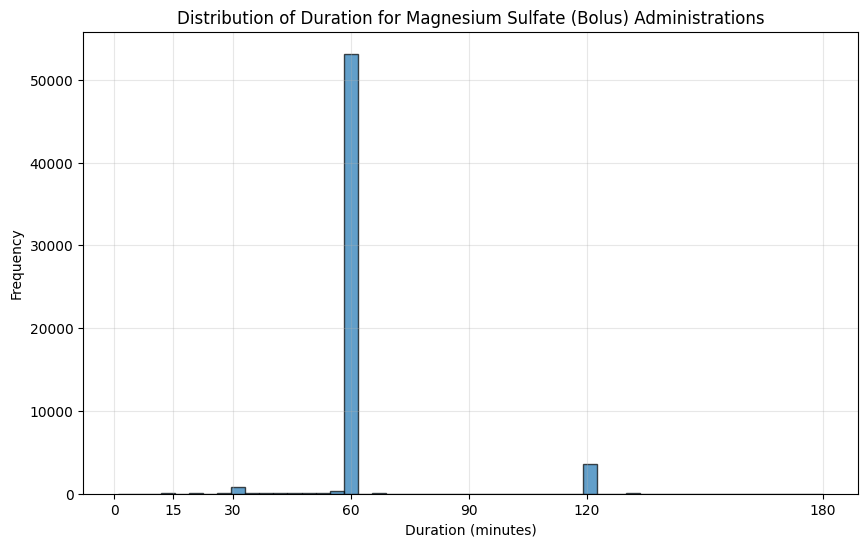

Total records: 58784
Duration statistics:
count    58784.000000
mean        63.094635
std         15.694322
min          1.000000
25%         60.000000
50%         60.000000
75%         60.000000
max        180.000000
Name: _duration_in_mins, dtype: float64


In [66]:
import matplotlib.pyplot as plt

# Plot histogram of _duration_in_mins for mg_bolus
plt.figure(figsize=(10, 6))
plt.hist(mg_bolus['_duration_in_mins'], bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Duration for Magnesium Sulfate (Bolus) Administrations')

# Mark specific time points on x-axis
plt.xticks([0, 15, 30, 60, 90, 120, 180], ['0', '15', '30', '60', '90', '120', '180'])

#plt.legend()
#plt.xscale('log')
#plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.show()

# Print some summary statistics
print(f"Total records: {len(mg_bolus)}")
print(f"Duration statistics:")
print(mg_bolus['_duration_in_mins'].describe())


## Impute missing dose `rate`

for the four meds in `cont_rate_missing_summ`, we use amount divided by duration to impute a dose rate that fills the original missing ones

In [67]:
q = """
SELECT * REPLACE(
    COALESCE(rate, amount / _duration_in_mins) as rate
    , COALESCE(rateuom, amountuom || '/min') as rateuom
)
FROM cont_reassembled
"""
cont_null_dose_rate_imputed = duckdb.sql(q)#.df()

## Remove duplicates before timestamp flattening

In [68]:
q = """
FROM cont_null_dose_rate_imputed
SELECT *
    , n: COUNT(*) OVER (PARTITION BY hadm_id, starttime, endtime, med_category, linkorderid)
QUALIFY n > 1
"""
dups = duckdb.sql(q).df()

In [85]:
q = """
SELECT *
FROM cont_null_dose_rate_imputed
QUALIFY ROW_NUMBER() OVER (
    PARTITION BY hadm_id, linkorderid, med_category, starttime, endtime
    ORDER BY hadm_id
) = 1
"""
cont_deduped_by_timestamps = duckdb.sql(q)
print(f"Removed {cont_null_dose_rate_imputed.shape[0] - cont_deduped_by_timestamps.shape[0]} rows")

Removed 11 rows


## Intermittent (Archive)
This part needs updating as it was built to generate cont only without considering keeping intm.

First identify the intermittents and observe their pattern.

In [70]:
query = f"""
SELECT *
    -- flags to identify intermittents
    , CASE WHEN ordercategoryname = '05-Med Bolus'
        THEN 1 ELSE 0 END AS _intm_by_ordercategoryname
    , CASE WHEN ordercategorydescription = 'Drug Push'
        THEN 1 ELSE 0 END AS _intm_by_ordercategorydescription
    , CASE WHEN statusdescription = 'Bolus'
        THEN 1 ELSE 0 END AS _intm_by_statusdescription
    -- flags to count discrepencies, i.e. if all of the ostensible intermittents satisfy the 1min duration rule
    , CASE WHEN _intm_by_ordercategorydescription = 1 AND _last_1min = 0
        THEN 1 ELSE 0 END AS not_1min_ordercategorydescription
    , CASE WHEN _intm_by_ordercategoryname = 1 AND _last_1min = 0
        THEN 1 ELSE 0 END AS not_1min_ordercategoryname
    , CASE WHEN _intm_by_statusdescription = 1 AND _last_1min = 0
        THEN 1 ELSE 0 END AS not_1min_statusdescription
FROM mapped_and_augmented
WHERE {find_intm_where_clause}

"""
intm_only = duckdb.sql(query).df()

print(f"# of intermittents identified through ordercategoryname that failed the 1-min rule: {intm_only.not_1min_ordercategoryname.sum()}")
print(f"# of intermittents identified through ordercategorydescription that failed the 1-min rule: {intm_only.not_1min_ordercategorydescription.sum()}")
print(f"# of intermittents identified through statusdescription that failed the 1-min rule: {intm_only.not_1min_statusdescription.sum()}")

BinderException: Binder Error: Referenced column "ordercategoryname" not found in FROM clause!
Candidate bindings: "_intm_by_ordercategoryname", "med_route_category", "med_category", "_intm_by_ordercategorydescription", "rate"

From the result it seems `_intm_by_statusdescription` is particularly messy, while the other two can be used to safety identify intermittents.

In [ ]:
query = """
SELECT *
FROM intm_only
WHERE not_1min_statusdescription = 1
"""
df = duckdb.sql(query).df()

# check if any of continuous events has 1-min duration # FIXME: possibly outdated
query = f"""
SELECT *
FROM mapped_and_augmented
WHERE NOT ({find_intm_where_clause})
"""
intermittent_removed = duckdb.sql(query).df()

query = f"""
SELECT *
FROM intermittent_removed
WHERE _last_1min = 1
"""
cont_yet_1min = duckdb.sql(query).df()

## Flatten timestamps

In [71]:
# check monotonicity
q = """
SELECT *
    , LAG(endtime) OVER (PARTITION BY hadm_id, med_category, linkorderid ORDER BY starttime) AS endtime_prev
    , starttime < endtime_prev AS crossover
FROM cont_null_dose_rate_imputed
QUALIFY crossover is True
-- ORDER BY hadm_id, med_category, starttime, endtime, linkorderid
ORDER BY hadm_id, starttime, endtime, linkorderid, med_category
"""
crossovers = duckdb.sql(q).df()
print(f"given there are only {len(crossovers)} cases, we are just gonna ignore them")

given there are only 38 cases, we are just gonna ignore them


### Cont - new

In [ ]:
q = """
-- pivot to longer and create the fill-in [Started] and [Restarted] MAR actions from 'starttime'
WITH longer as (
    PIVOT_LONGER cont_deduped_by_timestamps
    ON starttime, endtime
    INTO NAME _timestamp_type
        VALUE admin_dttm
)
FROM longer
SELECT hospitalization_id: hadm_id
    , med_order_id: linkorderid
    , med_name: label
    , med_category
    , admin_dttm
    , _rn: ROW_NUMBER() OVER (PARTITION BY hospitalization_id, med_order_id, med_category ORDER BY admin_dttm)
    , mar_action_name: CASE 
        WHEN statusdescription = 'Bolus' AND _timestamp_type = 'starttime'
            THEN '[Started Bolus]'
        WHEN statusdescription = 'Bolus' AND _timestamp_type = 'endtime'
            THEN '[Finished Bolus]'
        WHEN _timestamp_type = 'starttime' 
            AND _rn = 1
            THEN '[Started]' 
        WHEN _timestamp_type = 'starttime' 
            AND _rn > 1
            THEN '[Restarted]'
        ELSE statusdescription END
    , med_dose: rate
    , med_dose_unit: rateuom
ORDER BY hospitalization_id, med_order_id, med_category, admin_dttm, mar_action_name
"""
cont_flattened = duckdb.sql(q).df()

In [ ]:
q = """
FROM cont_flattened
SELECT hospitalization_id, med_order_id, med_category, admin_dttm
    , mar_action_names: STRING_AGG(mar_action_name, ', ' ORDER BY mar_action_name)
    , n: COUNT(*)
GROUP BY hospitalization_id, med_order_id, med_category, admin_dttm
HAVING n > 1
ORDER BY n DESC, hospitalization_id, med_order_id, med_category, admin_dttm
"""
cont_mar_action_dups = duckdb.sql(q).df()

In [ ]:
q = """
FROM cont_mar_action_dups
SELECT mar_action_names
    , n: COUNT(*)
    , mar_action_name_to_display: CASE
        WHEN mar_action_names = 'ChangeDose/Rate, [Restarted]' THEN 'ChangeDose/Rate'
        --WHEN mar_action_names = 'Paused, [Restarted]' THEN '[Restarted]'
        --WHEN mar_action_names = 'ChangeDose/Rate, [Started Bolus]' THEN '[Started Bolus]'
        ELSE mar_action_names END
    , mar_action_name_w_correct_dose: CASE
        WHEN '[Restarted]' IN mar_action_names THEN '[Restarted]'
        WHEN '[Started Bolus]' IN mar_action_names THEN '[Started Bolus]'
        ELSE 'FinishedRunning' END
GROUP BY mar_action_names
ORDER BY n DESC
"""
mar_action_dedup_mapping = duckdb.sql(q).df()

# RESUME

In [90]:
pd.read_csv(mapping_path_finder("mar_action_dedup"))

,mar_action_names,n,mar_action_name_to_display,mar_action_name_w_correct_dose
0,"ChangeDose/Rate, [Restarted]",2941979,ChangeDose/Rate,[Restarted]
1,"Paused, [Restarted]",12085,"Paused, [Restarted]",[Restarted]
2,"ChangeDose/Rate, [Started Bolus]",474,"ChangeDose/Rate, [Started Bolus]",[Started Bolus]
3,"[Finished Bolus], [Restarted]",88,"[Finished Bolus], [Restarted]",[Restarted]
4,"[Finished Bolus], [Started Bolus]",51,"[Finished Bolus], [Started Bolus]",[Started Bolus]
5,"ChangeDose/Rate, [Restarted], [Restarted]",6,"ChangeDose/Rate, [Restarted], [Restarted]",[Restarted]
6,"Paused, [Started Bolus]",2,"Paused, [Started Bolus]",[Started Bolus]
7,"Reported, [Restarted]",1,"Reported, [Restarted]",[Restarted]


### Intm

In [75]:
q = """
FROM intm_reassembled
SELECT hospitalization_id: hadm_id
    , med_order_id: linkorderid
    , med_name: label
    , med_category
    , admin_dttm: starttime
    , mar_action_name: statusdescription
    , mar_action_category: 'given'
    , med_dose: amount
    , med_dose_unit: LAST_VALUE(amountuom IGNORE NULLS) OVER (
        PARTITION BY hospitalization_id, med_order_id, med_category 
        ORDER BY admin_dttm
        ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
        )
ORDER BY hospitalization_id, med_order_id, med_category, admin_dttm
"""
intm_flattened = duckdb.sql(q).df()

In [88]:
len(intm_reassembled)

3252010

### Testing

In [ ]:
import pandas as pd
from pathlib import Path
from src.tables.medication_admin import _flatten_timestamps_staging, _flatten_timestamps

# Load input data
input_path = Path('tests/fixtures/med_admin/mimic-to-clif-test-fixtures - med_admin_in.csv')
test_df = pd.read_csv(input_path)
# drop columns that start with 'Column'
test_df.drop(columns=[col for col in test_df.columns if col.startswith('Column')], inplace=True)
test_df['starttime'] = pd.to_datetime(test_df['starttime'])
test_df['endtime'] = pd.to_datetime(test_df['endtime'])
test_df['_duration_in_mins'] = (test_df['endtime'] - test_df['starttime']).dt.total_seconds()/ 60

# Load expected output
expected_path = Path('tests/fixtures/med_admin/mimic-to-clif-test-fixtures - med_admin_out.csv')
expected_df = pd.read_csv(expected_path)
expected_df['admin_dttm'] = pd.to_datetime(expected_df['admin_dttm'], format='mixed')
expected_df['hospitalization_id'] = expected_df['hospitalization_id'].astype(str)
expected_df['med_order_id'] = expected_df['med_order_id'].astype(str)

# === Run the pipeline ===
staging_df = _flatten_timestamps_staging(test_df, "rate")
result_df = _flatten_timestamps(staging_df, "rate")

# Convert ID columns to string to match CLIF schema
result_df['hospitalization_id'] = result_df['hospitalization_id'].astype(str)
result_df['med_order_id'] = result_df['med_order_id'].astype(str)

# === Sort both dataframes ===
sort_cols = ['hospitalization_id', 'med_order_id', 'med_category', 'admin_dttm', 'med_dose']
result_sorted = result_df.sort_values(by=sort_cols).reset_index(drop=True)
expected_sorted = expected_df.sort_values(by=sort_cols).reset_index(drop=True)

## Resolve duplicates

### Cont

In [94]:
q = """
WITH base as (
    FROM cont_flattened
    SELECT *
        , mar_action_names: STRING_AGG(mar_action_name, ', ' ORDER BY mar_action_name) 
            OVER (PARTITION BY hospitalization_id, med_order_id, med_category, admin_dttm)
), mapped as (
    FROM base b
    LEFT JOIN mar_action_dedup_mapping m USING (mar_action_names)
    SELECT * 
)
FROM mapped
SELECT hospitalization_id
    , med_order_id
    , med_name
    , med_category
    , admin_dttm
    , mar_action_name: COALESCE(mar_action_name_to_display, mar_action_name) 
    , mar_action_category: CASE
        WHEN 'ChangeDose/Rate' in mar_action_name OR 'Bolus' in mar_action_name
            THEN 'dose_change'
        WHEN mar_action_name in ('[Started]', '[Restarted]') THEN 'start'
        WHEN mar_action_name in ('FinishedRunning', 'FinishedRunning, FinishedRunning', 'Stopped', 'Paused', 'Bolus') THEN 'stop'
        WHEN '[Restarted]' in mar_action_name THEN 'going'
        ELSE 'other' END
    , med_dose
    , med_dose_unit
WHERE mar_action_name_w_correct_dose = mar_action_name
    OR mar_action_name_w_correct_dose IS NULL -- when there are no duplicates
QUALIFY ROW_NUMBER() OVER (
    PARTITION BY hospitalization_id, med_category, admin_dttm, med_order_id
) = 1
ORDER BY hospitalization_id, med_order_id, med_category, admin_dttm
"""
cont_deduped = duckdb.sql(q).df()

In [95]:
query = """
SELECT *
FROM cont_deduped
QUALIFY COUNT(*) OVER (PARTITION BY hospitalization_id, med_category, admin_dttm, med_order_id) > 1
"""
cont_dups = duckdb.sql(query).df()

In [78]:
len_pre = len(cont_deduped)
cont_deduped.drop_duplicates(subset=['hospitalization_id', 'med_category', 'admin_dttm', 'med_order_id', 'med_dose_unit'], inplace=True)
len_post = len(cont_deduped)
print(f"Removed {len_pre - len_post} rows")

Removed 6 rows


### Intm

In [80]:
query = """
SELECT *
FROM intm_flattened
QUALIFY COUNT(*) OVER (PARTITION BY hospitalization_id, med_category, admin_dttm, med_order_id, med_dose_unit) > 1
"""
intm_dups = duckdb.sql(query).df()
assert len(intm_dups) == 0, 'there are still rows in the intermittent table that are duplicated'

## Save

In [ ]:
save_to_rclif(cont_deduped, 'medication_admin_continuous')
save_to_rclif(intm_flattened, 'medication_admin_intermittent')

2025-10-23 17:32:40,368 - INFO - saving medication_admin_continuous rclif table as a parquet file at /Users/wliao0504/code/clif/CLIF-MIMIC/src/../output/rclif-dev-test/clif_medication_admin_continuous.parquet.
2025-10-23 17:32:42,051 - INFO - saving medication_admin_intermittent rclif table as a parquet file at /Users/wliao0504/code/clif/CLIF-MIMIC/src/../output/rclif-dev-test/clif_medication_admin_intermittent.parquet.


# Find testing data

In [ ]:
hosp_demo = pd.read_parquet('tests/clif_hospitalization.parquet')

In [ ]:
q = f"""
FROM mapped_and_augmented p
INNER JOIN hosp_demo d ON (d.hospitalization_id = p.hadm_id)
SELECT p.*
ORDER BY hospitalization_id, linkorderid, med_category, starttime, endtime
"""
med_events_demo = duckdb.sql(q).df()